In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# Bias–Variance Tradeoff

En este notebook se estudia el **Bias–Variance Tradeoff**, uno de los conceptos fundamentales en aprendizaje automático, que describe el compromiso entre la capacidad de un modelo para ajustarse a los datos y su capacidad de generalizar a datos no vistos.


## 1. Generación de los datos

En primer lugar, se generan datos sintéticos a partir de una función conocida.  
Se añade ruido gaussiano para simular observaciones reales.


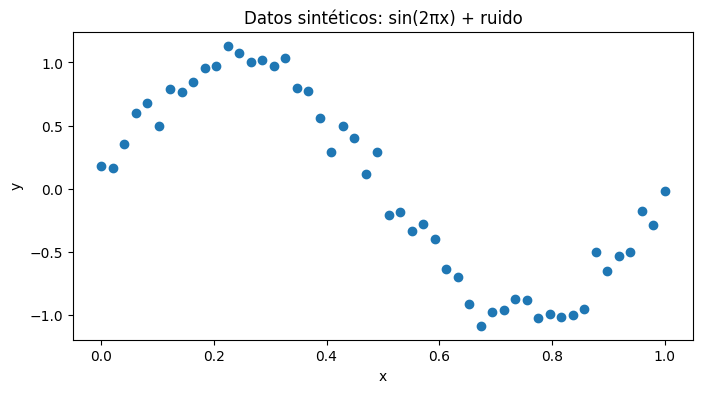

In [15]:
# Parámetros del experimento
np.random.seed(0)
n_samples = 50

# Variable independiente
X = np.linspace(0, 1, n_samples).reshape(-1, 1)

# Función real (desconocida para el modelo) + ruido
noise_std = 0.1
y = np.sin(2 * np.pi * X).ravel() + np.random.normal(0, noise_std, size=n_samples)

# Visualización
plt.figure(figsize=(8, 4))
plt.scatter(X, y)
plt.title("Datos sintéticos: sin(2πx) + ruido")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## 2. Separación Train/Test

Para estudiar la generalización, dividimos los datos en conjunto de entrenamiento (*train*) y de test (*test*).  
El modelo se entrena con *train* y se evalúa con *test*.


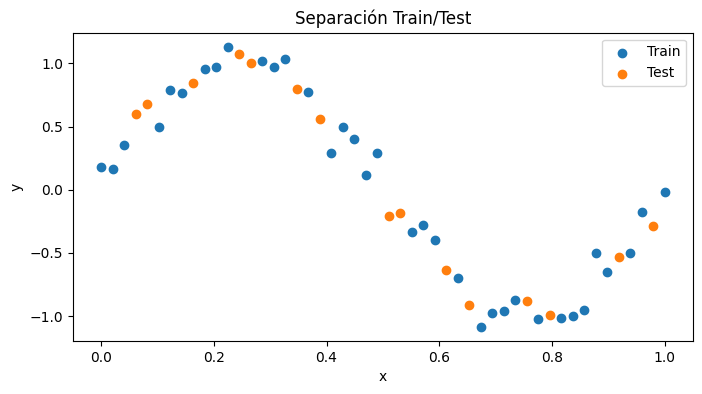

Train size: 35
Test size: 15


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

plt.figure(figsize=(8, 4))
plt.scatter(X_train, y_train, label="Train")
plt.scatter(X_test, y_test, label="Test")
plt.title("Separación Train/Test")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


## 3. Modelos con distinta complejidad

A continuación se entrenan modelos de regresión polinómica con distintos grados.  
El grado del polinomio controla la **complejidad del modelo**:

- Grados bajos → modelos simples (alto bias)
- Grados altos → modelos complejos (alta varianza)


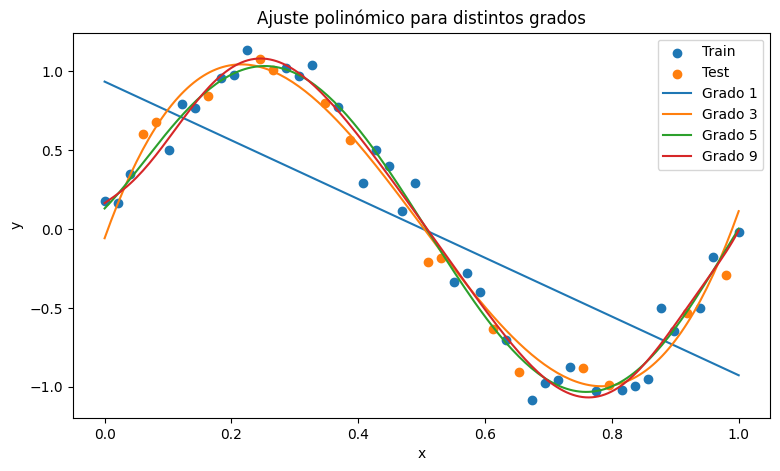

In [17]:
degrees = [1, 3, 5, 9]

X_plot = np.linspace(0, 1, 200).reshape(-1, 1)

plt.figure(figsize=(9, 5))
plt.scatter(X_train, y_train, label="Train")
plt.scatter(X_test, y_test, label="Test")

for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_plot_poly = poly.transform(X_plot)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_plot = model.predict(X_plot_poly)
    plt.plot(X_plot, y_plot, label=f"Grado {d}")

plt.title("Ajuste polinómico para distintos grados")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


Grado  1 | MSE train = 0.2253 | MSE test = 0.1720
Grado  3 | MSE train = 0.0177 | MSE test = 0.0105
Grado  5 | MSE train = 0.0112 | MSE test = 0.0118
Grado  9 | MSE train = 0.0104 | MSE test = 0.0155


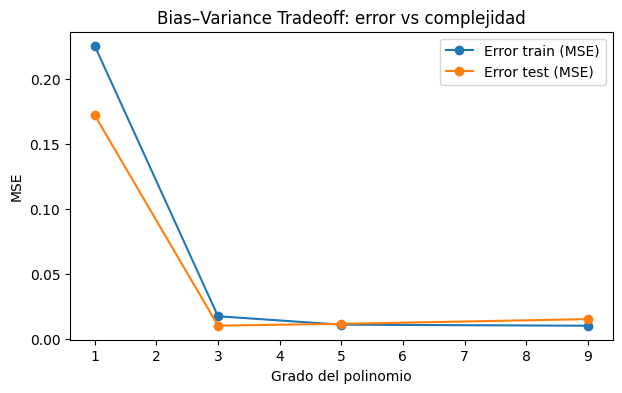

In [19]:
train_errors = []
test_errors = []

for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

# Mostrar tabla rápida
for d, tr, te in zip(degrees, train_errors, test_errors):
    print(f"Grado {d:>2} | MSE train = {tr:.4f} | MSE test = {te:.4f}")

# Gráfica de errores
plt.figure(figsize=(7, 4))
plt.plot(degrees, train_errors, marker="o", label="Error train (MSE)")
plt.plot(degrees, test_errors, marker="o", label="Error test (MSE)")
plt.title("Bias–Variance Tradeoff: error vs complejidad")
plt.xlabel("Grado del polinomio")
plt.ylabel("MSE")
plt.legend()
plt.show()


A partir de la gráfica anterior se observa claramente el **Bias–Variance Tradeoff**.

- Para **grados bajos**, el modelo es demasiado simple y no captura la relación no lineal de los datos, lo que produce un **alto bias** (*underfitting*).
- Para **grados altos**, el modelo se ajusta muy bien a los datos de entrenamiento, pero su error en test aumenta debido a la **alta varianza** (*overfitting*).
- Para un **grado intermedio**, el error de test es mínimo, indicando un equilibrio óptimo entre sesgo y varianza.

Este comportamiento es característico del compromiso entre complejidad del modelo y capacidad de generalización.


## 4. Experimento Monte Carlo: estimación empírica de Bias y Varianza

Hasta ahora hemos analizado el comportamiento del error para un único conjunto de datos.  
Sin embargo, el **Bias–Variance Tradeoff** se define considerando la variabilidad del modelo frente a distintos conjuntos de datos.

Para ello, repetimos el experimento varias veces generando nuevos datos con distinto ruido (*Monte Carlo*) y analizamos cómo varían las predicciones del modelo.


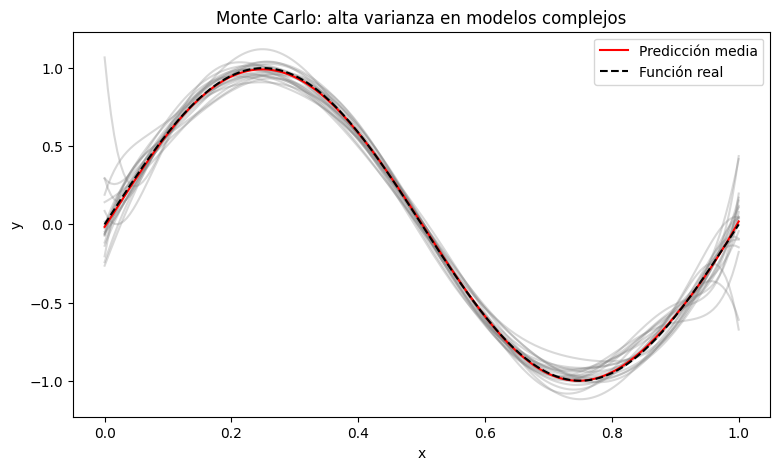

In [20]:
# Parámetros Monte Carlo
n_runs = 100
degree_mc = 9   # modelo complejo para observar varianza
X_plot = np.linspace(0, 1, 200).reshape(-1, 1)

predictions = []

for i in range(n_runs):
    # Generar nuevo dataset con distinto ruido
    y_mc = np.sin(2 * np.pi * X).ravel() + np.random.normal(0, noise_std, size=n_samples)

    X_train_mc, _, y_train_mc, _ = train_test_split(
        X, y_mc, test_size=0.3
    )

    poly = PolynomialFeatures(degree=degree_mc)
    X_train_poly = poly.fit_transform(X_train_mc)
    X_plot_poly = poly.transform(X_plot)

    model = LinearRegression()
    model.fit(X_train_poly, y_train_mc)

    predictions.append(model.predict(X_plot_poly))

predictions = np.array(predictions)

# Predicción media y varianza
mean_prediction = predictions.mean(axis=0)
variance_prediction = predictions.var(axis=0)

# Función real
y_true = np.sin(2 * np.pi * X_plot)

# Visualización
plt.figure(figsize=(9, 5))

for i in range(20):
    plt.plot(X_plot, predictions[i], color="gray", alpha=0.3)

plt.plot(X_plot, mean_prediction, color="red", label="Predicción media")
plt.plot(X_plot, y_true, color="black", linestyle="--", label="Función real")

plt.title("Monte Carlo: alta varianza en modelos complejos")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


En la figura anterior se observa el comportamiento característico de un modelo de **alta complejidad** frente a distintos conjuntos de datos.

- Las diferentes curvas grises representan las predicciones obtenidas al entrenar el modelo con distintos datasets.
- La gran dispersión entre estas curvas indica una **alta varianza**, ya que pequeñas variaciones en los datos producen modelos muy distintos.
- La predicción media (curva roja) se aproxima a la función real, lo que implica un **bias reducido**.

Este experimento ilustra de forma empírica cómo los modelos complejos presentan baja capacidad de sesgo pero alta sensibilidad a los datos.


## 5. Conclusiones

En este notebook se ha estudiado el **Bias–Variance Tradeoff** mediante experimentos controlados de regresión polinómica.

Se ha observado que:
- Los modelos simples presentan **alto bias** y tienden al *underfitting*.
- Los modelos complejos presentan **alta varianza** y tienden al *overfitting*.
- Existe una complejidad intermedia que minimiza el error de generalización.

Además, mediante un experimento Monte Carlo se ha ilustrado de forma empírica cómo la varianza del modelo aumenta con la complejidad, confirmando las definiciones teóricas del tradeoff.


---

**Autor:** Javier Santabárbara Borén   
**Asignatura:** Aprendizaje automático  
**Grado:** Ingeniería Informática y ADE  
**Universidad:** CUNEF  
**Año:** 2025
